# Applying BERT Multilingual Classifier to Predict Account Suspension 

Phase 2

Guidance from: https://github.com/kacossio/TeamPython/blob/master/Bert%20Multilingual%20Embedding.ipynb

## 1. Load Packages

In [1]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import emoji
import random 
import math

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## 2. Set parameters

In [2]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

import_bucket = "data/s3_data/full_clean/"

embedding_bucket = "data/s3_data/embeddings/final_embeddings_textclass/"

results_bucket = 'data/s3_data/' # already created on S3

## 3. Load in Data

### Load in data from S3 - Original Data

In [3]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train = pd.read_csv(import_bucket + "df_train_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_train['suspended'] = pd.to_numeric(df_train['suspended'], errors='coerce')
df_train = df_train[df_train['suspended'].notna()]

# Import Test and Measure Balance

df_test = pd.read_csv(import_bucket + "df_test_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_test['suspended'] = pd.to_numeric(df_test['suspended'], errors='coerce')
df_test = df_test[df_test['suspended'].notna()]

# Import Validation and Measure Balance
# Import Flattened Data
df_valid = pd.read_csv(import_bucket + "df_valid_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_valid['suspended'] = pd.to_numeric(df_valid['suspended'], errors='coerce')
df_valid = df_valid[df_valid['suspended'].notna()]

In [4]:
df_train = df_train.drop_duplicates(subset=['id'])
df_valid = df_valid.drop_duplicates(subset=['id'])
df_test = df_test.drop_duplicates(subset=['id'])

### Import Full Dataframes with Embeddings 

Multilingual

In [5]:
bert_embeddings_df_train = pd.read_csv(embedding_bucket + "multilingual/results/ml_training_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test = pd.read_csv(embedding_bucket + "multilingual/results/ml_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid = pd.read_csv(embedding_bucket + "multilingual/results/ml_valid_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')

In [6]:
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].astype('float')
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].astype('float')
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].astype('float')

Labse

In [7]:
bert_embeddings_df_train_labse = pd.read_csv(embedding_bucket + "labse/results/labse_train_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test_labse = pd.read_csv(embedding_bucket + "labse/results/labse_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid_labse = pd.read_csv(embedding_bucket + "labse/results/labse_valid_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')

In [8]:
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].astype('float')
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].astype('float')
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].astype('float')

### Check Lengths 

In [9]:
print("full train:", len(df_train), "unique ids train:", len(df_train['id'].unique()), 
      "full valid:", len(df_valid), "unique ids valid:", len(df_valid['id'].unique()), 
      "full test:", len(df_test), "unique ids test:", len(df_test['id'].unique()))

full train: 107374 unique ids train: 107374 full valid: 38537 unique ids valid: 38537 full test: 29139 unique ids test: 29139


In [10]:
print("full train:", len(bert_embeddings_df_train), "unique ids train:", len(bert_embeddings_df_train['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid), "unique ids valid:", len(bert_embeddings_df_valid['id'].unique()), 
      "full test:", len(bert_embeddings_df_test), "unique ids test:", len(bert_embeddings_df_test['id'].unique()))

full train: 115766 unique ids train: 115766 full valid: 35120 unique ids valid: 35120 full test: 34839 unique ids test: 34839


In [11]:
print("full train:", len(bert_embeddings_df_train_labse), "unique ids train:", len(bert_embeddings_df_train_labse['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid_labse), "unique ids valid:", len(bert_embeddings_df_valid_labse['id'].unique()), 
      "full test:", len(bert_embeddings_df_test_labse), "unique ids test:", len(bert_embeddings_df_test_labse['id'].unique()))

full train: 115766 unique ids train: 115766 full valid: 35120 unique ids valid: 35120 full test: 34839 unique ids test: 34839


## 5. Base Models: Fully Connected Models (No Fine-Tuning)

In [12]:
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
import pickle
import pandas as pd
import pickle
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow import keras
import random as rn
from keras.models import Model,save_model, load_model, Sequential
from keras.layers import Flatten,AveragePooling1D,Dropout,Dense,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import IPython
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.utils import to_categorical
import pydot
import graphviz
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt
from kerastuner import HyperModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


Get rid of perfect predictor vars 

In [13]:
bert_embeddings_df_train_fm = bert_embeddings_df_train.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm = bert_embeddings_df_valid.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm = bert_embeddings_df_test.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

In [14]:
bert_embeddings_df_train_fm_labse = bert_embeddings_df_train_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm_labse = bert_embeddings_df_valid_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm_labse = bert_embeddings_df_test_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

### Prep Data to Convert to Tensor

In [15]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,withheld_in_countries_['DE'],withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,

In [16]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train = bert_embeddings_df_train_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train = bert_embeddings_df_train_fm.iloc[:, bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train = bert_embeddings_df_train_fm['suspended']

#bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc(0)

#gets country label number
num_of_labels=labels_train.nunique()
num_of_labels

2

In [17]:
labels_train.unique()

array([0, 1])

#### Feature Selection

#### Option 1: Use Random Forest Feature Selection for Account Features 

I specify the random forest instance, indicating the number of trees. Then I use selectFromModel object from sklearn to automatically select the features.

To note, this is much faster than LASSO. 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Double check to ensure no missingness ahead of random forest feature selection 

In [19]:
pd.set_option('display.max_rows', None)
acct_features_train.isna().sum()

created_at                                     0
retweet_count                               1545
favorite_count                              1545
quoted_status_id                               0
user.favourites_count                          0
user.followers_count                           0
user.friends_count                             0
user.listed_count                              0
user.statuses_count                            0
quoted_status.user.followers_count             0
quoted_status.user.friends_count               0
retweeted_status.user.followers_count          0
retweeted_status.user.friends_count            0
user_age                                       0
tweets_per_day                                 0
since_last_tweet_mins                       1552
since_last_tweet_mins_min                      4
since_last_tweet_mins_max                      4
since_last_tweet_mins_mean                     4
avg_tweets_per_hr                              0
avg_tweets_per_day  

In [20]:
start_time = time.time()

acct_features_train['since_last_tweet_mins'] = pd.to_numeric(acct_features_train['since_last_tweet_mins'], errors='coerce')
acct_features_train['user.followers_countdailychange'] = pd.to_numeric(acct_features_train['user.followers_countdailychange'], errors='coerce')
acct_features_train['user.friends_countdailychange'] = pd.to_numeric(acct_features_train['user.friends_countdailychange'], errors='coerce')

acct_features_train = acct_features_train.replace([np.inf, -np.inf], np.nan)

acct_features_train = acct_features_train.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1370561122894287 seconds ---


In [21]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

random_seeds(1234)

In [22]:
feat_labels = acct_features_train.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(acct_features_train, labels_train)
importances = forest.feature_importances_ # probably even simpler than the code I had

indices = np.argsort(importances)[::-1]

In [23]:
for f in range(acct_features_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) avg_tweets_per_day             0.072202
 2) user.friends_countdailychange  0.066138
 3) since_last_tweet_mins_max      0.061241
 4) since_last_tweet_mins_mean     0.058375
 5) no_urls_per_tweet              0.055743
 6) avg_tweets_per_hr              0.054912
 7) user.urls_per_tweet            0.054179
 8) user.followers_countdailychange 0.052729
 9) user.friends_count             0.048483
10) user.favourites_count          0.047631
11) user.statuses_count            0.047511
12) no_hashtags_per_tweet          0.042143
13) no_mentions_per_tweet          0.039284
14) followers_per_followees        0.038503
15) user.followers_count           0.036628
16) tweets_per_day                 0.023880
17) user.followers_rate            0.023140
18) user.screen_name.digit_length  0.022906
19) user.screen_name.length        0.022748
20) created_at                     0.019981
21) user.friend_rate               0.018638
22) user_age                       0.014210
23) user.has_location          

In [24]:
sel = SelectFromModel(forest, prefit=True)
selected_feat= acct_features_train.columns[(sel.get_support())]
len(selected_feat)

25

In [25]:
selected_feat

Index(['created_at', 'user.favourites_count', 'user.followers_count',
       'user.friends_count', 'user.statuses_count', 'user_age',
       'tweets_per_day', 'since_last_tweet_mins_max',
       'since_last_tweet_mins_mean', 'avg_tweets_per_hr', 'avg_tweets_per_day',
       'followers_per_followees', 'user.urls_per_tweet',
       'no_hashtags_per_tweet', 'no_mentions_per_tweet', 'no_urls_per_tweet',
       'user.followers_countdailychange', 'user.friends_countdailychange',
       'user.friend_rate', 'user.followers_rate', 'user.has_location',
       'user.screen_name.digit_length', 'user.screen_name.length',
       'source_Twitter for Android', 'source_Twitter for iPhone'],
      dtype='object')

In [26]:
scaler = StandardScaler()

acct_features_train = acct_features_train[selected_feat]

# Scale account features 
acct_features_train[acct_features_train.columns] = scaler.fit_transform(acct_features_train[acct_features_train.columns])

combined_features_train = pd.concat([acct_features_train, text_feature_train], axis=1)

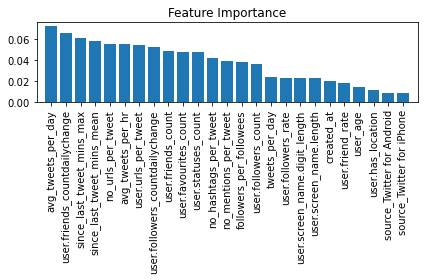

In [27]:
plt.title('Feature Importance')
plt.bar(range(acct_features_train.shape[1]), 
        importances[indices][0:len(selected_feat)],
        align='center')

plt.xticks(range(acct_features_train.shape[1]), 
           feat_labels[indices][0:len(selected_feat)], rotation=90)
plt.xlim([-1, acct_features_train.shape[1]])
plt.tight_layout()
plt.savefig(results_bucket + 'full_feature_importance.png', dpi=300)
plt.show()

#### Resume after feature selection

Valid

In [28]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid = bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid = bert_embeddings_df_valid_fm.iloc[:, bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid = bert_embeddings_df_valid_fm['suspended']

#gets country label number
num_of_labels_valid=labels_valid.nunique()
num_of_labels_valid

2

In [29]:
acct_features_valid = acct_features_valid[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [30]:
#pd.set_option('display.max_rows', None)
acct_features_valid.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            4
since_last_tweet_mins_mean           4
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees            162
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    313
user.friends_countdailychange      313
user.friend_rate                    19
user.followers_rate                451
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPhone            0
dtype: int64

In [31]:
start_time = time.time()

acct_features_valid['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid['user.followers_countdailychange'], errors='coerce')
acct_features_valid['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid['user.friends_countdailychange'], errors='coerce')

acct_features_valid = acct_features_valid.replace([np.inf, -np.inf], np.nan)

acct_features_valid = acct_features_valid.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.014469146728515625 seconds ---


In [32]:
len(acct_features_valid.columns)

25

Scale valid features

In [33]:
# Scale account features 
acct_features_valid[acct_features_valid.columns] = scaler.fit_transform(acct_features_valid[acct_features_valid.columns])

In [34]:
combined_features_valid = pd.concat([acct_features_valid, text_feature_valid], axis=1)

Test

In [35]:
acct_features_test = bert_embeddings_df_test_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test = bert_embeddings_df_test_fm.iloc[:, bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test = bert_embeddings_df_test_fm['suspended']

#gets country label number
num_of_labels_test=labels_test.nunique()
num_of_labels_test

2

In [36]:
acct_features_test = acct_features_test[selected_feat]

In [37]:
#pd.set_option('display.max_rows', None)
acct_features_test.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees             45
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    291
user.friends_countdailychange      291
user.friend_rate                     6
user.followers_rate                378
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPhone            0
dtype: int64

In [38]:
start_time = time.time()

acct_features_test['user.followers_countdailychange'] = pd.to_numeric(acct_features_test['user.followers_countdailychange'], errors='coerce')
acct_features_test['user.friends_countdailychange'] = pd.to_numeric(acct_features_test['user.friends_countdailychange'], errors='coerce')

acct_features_test = acct_features_test.replace([np.inf, -np.inf], np.nan)

acct_features_test = acct_features_test.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.015178918838500977 seconds ---


In [39]:
len(acct_features_test.columns)

25

In [40]:
# Scale account features 
acct_features_test[acct_features_test.columns] = scaler.fit_transform(acct_features_test[acct_features_test.columns])

In [41]:
combined_features_test = pd.concat([acct_features_test, text_feature_test], axis=1)

#### Calculate class weights to address class imbalance problem. 

In [42]:
mapping = {0:0, 1:1}

def data_prep(dataset):
    y = []
    for i in range(0,len(dataset)):
        y_val = np.zeros(2)
        y_val[mapping[dataset[i]]] = 1
        y.append(y_val)
    return np.array(y)

In [43]:
labels_train_fw = data_prep(labels_train)
len(labels_train_fw)

115766

In [44]:
class_counts = [0, 0]
for el in labels_train_fw :
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

#### Label Encoding

In [45]:
#Label encoding (Have not had work yet, but may on full data)
def label_encoding(labels):
    LE = LabelEncoder()
    fit=LE.fit(labels)
    labels =fit.transform(labels)
    labels = to_categorical(labels)
    return labels, fit

In [46]:
#Test label_encoding
labels_train, fit_train=label_encoding(labels_train)
labels_valid, fit_valid=label_encoding(labels_valid)
labels_test, fit_test=label_encoding(labels_test)

In [47]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

#set seed
random_seeds(1234)

#### LabSe Processing

In [48]:
### Prep Data to Convert to Tensor

In [49]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,withheld_in_countries_['DE'],withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,

In [50]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train_labse = bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train_labse = bert_embeddings_df_train_fm_labse.iloc[:, bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train_labse = bert_embeddings_df_train_fm_labse['suspended']

In [51]:
acct_features_train_labse = acct_features_train_labse[selected_feat]

In [52]:
acct_features_train_labse.isna().sum()

created_at                            0
user.favourites_count                 0
user.followers_count                  0
user.friends_count                    0
user.statuses_count                   0
user_age                              0
tweets_per_day                        0
since_last_tweet_mins_max             4
since_last_tweet_mins_mean            4
avg_tweets_per_hr                     0
avg_tweets_per_day                    0
followers_per_followees              89
user.urls_per_tweet                   0
no_hashtags_per_tweet                 0
no_mentions_per_tweet                 0
no_urls_per_tweet                     0
user.followers_countdailychange     984
user.friends_countdailychange       984
user.friend_rate                     10
user.followers_rate                1085
user.has_location                     0
user.screen_name.digit_length         0
user.screen_name.length               0
source_Twitter for Android            0
source_Twitter for iPhone             0


In [53]:
start_time = time.time()

acct_features_train_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.followers_countdailychange'], errors='coerce')
acct_features_train_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.friends_countdailychange'], errors='coerce')

acct_features_train_labse = acct_features_train_labse.replace([np.inf, -np.inf], np.nan)

acct_features_train_labse = acct_features_train_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.04825305938720703 seconds ---


In [54]:
len(acct_features_train_labse.columns)

25

Standardize features

In [55]:
acct_features_train_labse[acct_features_train_labse.columns] = scaler.fit_transform(acct_features_train_labse[acct_features_train_labse.columns])

In [56]:
combined_features_train_labse = pd.concat([acct_features_train_labse, text_feature_train_labse], axis=1)

In [57]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid_labse = bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid_labse = bert_embeddings_df_valid_fm_labse.iloc[:, bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid_labse = bert_embeddings_df_valid_fm_labse['suspended']

In [58]:
acct_features_valid_labse = acct_features_valid_labse[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [59]:
acct_features_valid_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            4
since_last_tweet_mins_mean           4
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees            162
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    313
user.friends_countdailychange      313
user.friend_rate                    19
user.followers_rate                451
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPhone            0
dtype: int64

In [60]:
start_time = time.time()

acct_features_valid_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.followers_countdailychange'], errors='coerce')
acct_features_valid_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.friends_countdailychange'], errors='coerce')

acct_features_valid_labse = acct_features_valid_labse.replace([np.inf, -np.inf], np.nan)

acct_features_valid_labse = acct_features_valid_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.012869119644165039 seconds ---


In [61]:
len(acct_features_valid_labse.columns)

25

Standardize Features

In [62]:
acct_features_valid_labse[acct_features_valid_labse.columns] = scaler.fit_transform(acct_features_valid_labse[acct_features_valid_labse.columns])

In [63]:
combined_features_valid_labse = pd.concat([acct_features_valid_labse, text_feature_valid_labse], axis=1)

In [64]:
acct_features_test_labse = bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test_labse = bert_embeddings_df_test_fm_labse.iloc[:, bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test_labse = bert_embeddings_df_test_fm_labse['suspended']

In [65]:
acct_features_test_labse = acct_features_test_labse[selected_feat]

In [66]:
#pd.set_option('display.max_rows', None)
acct_features_test_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees             45
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    291
user.friends_countdailychange      291
user.friend_rate                     6
user.followers_rate                378
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPhone            0
dtype: int64

In [67]:
start_time = time.time()

acct_features_test_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.followers_countdailychange'], errors='coerce')
acct_features_test_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.friends_countdailychange'], errors='coerce')

acct_features_test_labse = acct_features_test_labse.replace([np.inf, -np.inf], np.nan)

acct_features_test_labse = acct_features_test_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.014389991760253906 seconds ---


In [68]:
len(acct_features_test_labse.columns)

25

Standardize Features

In [69]:
acct_features_test_labse[acct_features_test_labse.columns] = scaler.fit_transform(acct_features_test_labse[acct_features_test_labse.columns])

In [70]:
combined_features_test_labse = pd.concat([acct_features_test_labse, text_feature_test_labse], axis=1)

In [71]:
labels_train_fw_labse = data_prep(labels_train_labse)
len(labels_train_fw_labse)

115766

In [72]:
class_counts = [0, 0]
for el in labels_train_fw_labse :
    class_counts[np.argmax(el)]+=1
class_weights_labse = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

In [73]:
#Test label_encoding
labels_train_labse, fit_train_labse=label_encoding(labels_train_labse)
labels_valid_labse, fit_valid_labse=label_encoding(labels_valid_labse)
labels_test_labse, fit_test_labse=label_encoding(labels_test_labse)

#### Account only model  

In [74]:
#make sure numpy array
train_data_acc = np.array(acct_features_train).astype(np.float32)
valid_data_acc = np.array(acct_features_valid).astype(np.float32)
test_data_acc = np.array(acct_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [75]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(25,)

In [76]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_of_labels, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x) # SHOULD WE CONSIDER INCREASING TOP 0.5?
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

# DO WE NEED DROPOUT AFTER EACH LAYER INSTEAD OF RIGHT AT THE END? 

In [77]:
#model flow and summary
Acc_model = model_flow("Account_Info",num_of_labels, input_shape_acc)
Acc_model.summary()

Model: "Account_Info"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 25)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1664      
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                

In [78]:
#Compile  model
Acc_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
#Fitting on training and validation data
print("Fit model on Account Information features training data")
history_acc = Acc_model.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight=class_weights)

Fit model on Account Information features training data
Epoch 1/2
7718/7718 [==============================] - 13s 2ms/step - loss: 0.5638 - accuracy: 0.8557 - val_loss: 1.5778 - val_accuracy: 0.7485
Epoch 2/2
7718/7718 [==============================] - 10s 1ms/step - loss: 0.2028 - accuracy: 0.9547 - val_loss: 2.0441 - val_accuracy: 0.7734


In [80]:
# Evaluate the model on the test data
print("Evaluate on Account Information features test data")
Acc_model_results = Acc_model.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate on Account Information features test data
3484/3484 [==============================] - 3s 776us/step - loss: 0.6217 - accuracy: 0.8976


#### Save Model 

In [81]:
from tensorflow.keras.layers import LeakyReLU
Acc_model.save('data/s3_data/model_output/full_test_interp_Acc_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load back in model 

In [82]:
from tensorflow.keras.models import load_model

Acc_model = load_model('data/s3_data/model_output/full_test_interp_Acc_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Make Predictions

For Tweets

In [83]:
# Generate predictions (location probabilities)
def predict_test(model,test_data, test_labels, fit):
    predictions = model.predict(test_data)
    #y_true=np.argmax(test_labels, axis=0) 
    #y_pred=np.argmax(predictions, axis =0)
    #get labels of prediction
    #label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
    return report # label_pred

In [84]:
#test predict_test
metrics_report_acc=predict_test(Acc_model,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc)


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     31795
           1       0.43      0.52      0.47      3044

    accuracy                           0.90     34839
   macro avg       0.69      0.73      0.71     34839
weighted avg       0.91      0.90      0.90     34839



In [85]:
predictions = Acc_model.predict(test_data_acc)

In [86]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  

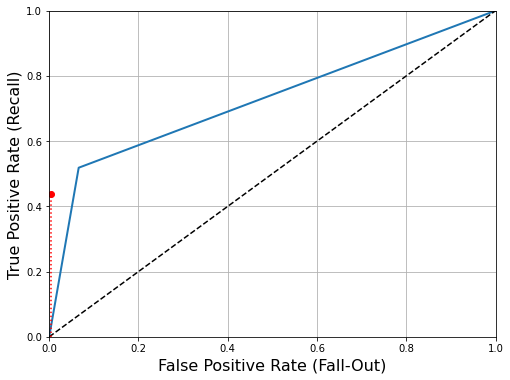

In [87]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [88]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.7261586369975692

For Accounts

In [89]:
# Generate summed probabilities at the account level 
def predict_account(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.25, 1,0) # Use lighter threshold as not all tweets get an account suspended. 
    df_4 = df_4.sort_values(by=['total_pre_prob'], ascending=False)

    return df_4

In [90]:
# Generate summed probabilities at the account level 
def predict_tweet_text(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['id'], df, left_index=True, right_index=True)
    df_fm = df_full[['id', 'text','user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_fm['id'] = df_fm['id'].apply(lambda x: x.replace("'", ''))
    df_fm['id'] = df_fm['id'].astype('float')
    df_fm['id'] = df_fm['id'].astype('str')
    df_fm['id'] = df_fm['id'].apply(lambda x: "'" + x + "'")
    df_2['id'] = df_2['id'].astype('str')
    df_2['id'] = df_2['id'].apply(lambda x: "'" + x + "'")
    df_3 = pd.merge(df_fm, df_2, left_on='id', right_on='id')
    df_3.columns = ["id", "text", "user.screen_name", "user.id", "suspended_label", "pred"]
    df_3 = df_3.sort_values(by=['pred'], ascending=False)

    return df_3

In [91]:
test_preds_tweets = predict_tweet_text(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
57,'1.2819424790891438e+18',RT arynewsud ARYNewsUrdu https co MgElm b,MariamS44046005,1.281940e+18,0,0.999990
2,'1.2818313918278287e+18',QasimKhanSuri Ameen,Haseenk53608977,1.278264e+18,0,0.998368
86,'1.310787317917913e+18',bbcchinese cant breathe,tracyCHBJ,1.286518e+18,0,0.996474
41,'1.2829102743459922e+18',RT China CCYL https,yQg5K3B7ZvLSZXQ,1.280441e+18,0,0.996211
20,'1.2804613421730035e+18',Abhiram You are so ignorant,WvU46oIgqdh88d0,1.279099e+18,0,0.985254


In [92]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [93]:
test_account_preds_acc = predict_account(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)

In [94]:
test_account_preds_acc.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [95]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc = classification_report(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
print(report_te_acc)

              precision    recall  f1-score   support

           0       0.97      0.61      0.75       102
           1       0.05      0.50      0.09         4

    accuracy                           0.60       106
   macro avg       0.51      0.55      0.42       106
weighted avg       0.93      0.60      0.72       106



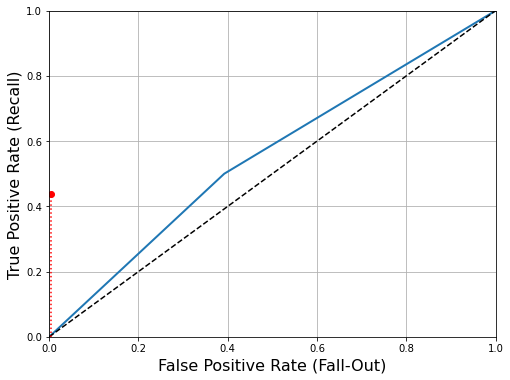

In [96]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [97]:
roc_auc_score(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))

0.553921568627451

Tweet Model Results

In [98]:
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

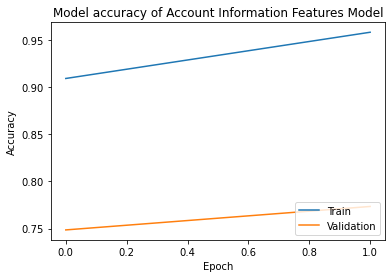

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6217131614685059, 0.8976147174835205]


In [99]:
#train vs validation accuracy plot
plot_acc=accuracy_plot('Model accuracy of Account Information Features Model', history_acc)
print(plot_acc)
#test accuracy and loss 
print("test loss, test accuracy:", Acc_model_results)

In [100]:
def loss_plot(title_, history_fit):
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title(title_)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

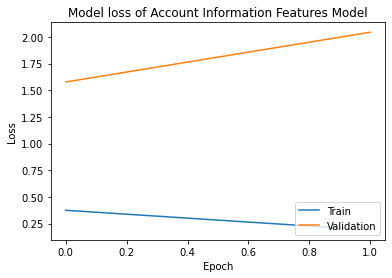

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6217131614685059, 0.8976147174835205]


In [101]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Account Information Features Model', history_acc)
print(plot_loss)
#test accuracy and loss
print("test loss, test accuracy:", Acc_model_results)

#### Combined Model

Multilingual

In [102]:
#make sure numpy array
train_data = np.array(combined_features_train).astype(np.float32)
valid_data = np.array(combined_features_valid).astype(np.float32)
test_data = np.array(combined_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [103]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(793,)

In [104]:
train_data[0].shape

(793,)

In [105]:
#set seed
random_seeds(1234)

In [106]:
#test model_flow
Combined_model = model_flow("Combined",num_of_labels, input_shape_combined)

In [107]:
#model summary
Combined_model.summary()


Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 793)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50816     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

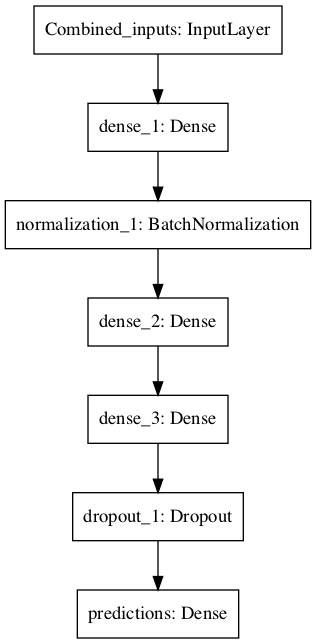

In [108]:
#model diagram
tf.keras.utils.plot_model(Combined_model)

In [109]:
#Compile  model
Combined_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [110]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined = Combined_model.fit(train_data, train_labels, epochs=2, batch_size=15,
                                      validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data
Epoch 1/2
7718/7718 [==============================] - 14s 2ms/step - loss: 0.7726 - accuracy: 0.8544 - val_loss: 0.7149 - val_accuracy: 0.7258
Epoch 2/2
7718/7718 [==============================] - 13s 2ms/step - loss: 0.6586 - accuracy: 0.8771 - val_loss: 0.7419 - val_accuracy: 0.7132


In [111]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb = Combined_model.evaluate(test_data, test_labels, batch_size=10)

Evaluate on test data
3484/3484 [==============================] - 3s 815us/step - loss: 0.5230 - accuracy: 0.8019


#### Save Model 

In [112]:
from tensorflow.keras.layers import LeakyReLU
Combined_model.save('data/s3_data/model_output/full_test_interp_Combined_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [113]:
from tensorflow.keras.models import load_model

Combined_model = load_model('data/s3_data/model_output/full_test_interp_Combined_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predictions

Tweets

In [114]:
#test predict_test
metrics_report_comb=predict_test(Combined_model,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     31795
           1       0.21      0.47      0.29      3044

    accuracy                           0.80     34839
   macro avg       0.58      0.65      0.59     34839
weighted avg       0.88      0.80      0.83     34839



In [115]:
predictions = Combined_model.predict(test_data)

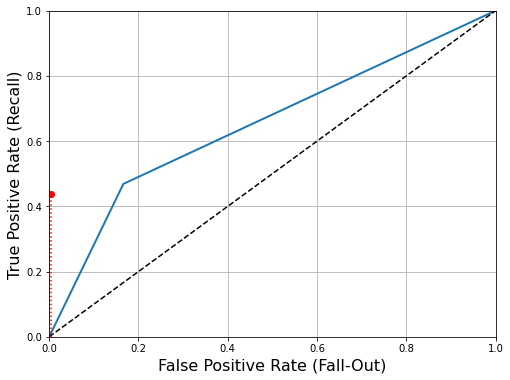

In [116]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [117]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.651316431706983

In [118]:
test_preds_tweets = predict_tweet_text(Combined_model, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
42,'1.2812576462308147e+18',TonySta Mane pahly bi kaya tha per os account...,abuzar_malik206,1.280674e+18,0,1.000000
73,'1.2905278435421676e+18',jame deane zhanglifan,Lance15234488,1.283652e+18,0,1.000000
57,'1.2819424790891438e+18',RT arynewsud ARYNewsUrdu https co MgElm b,MariamS44046005,1.281940e+18,0,0.999792
84,'1.287970610992124e+18',GaoyoaG JLin,JeremyC86978845,1.286251e+18,0,0.996163
32,'1.2800369559216292e+18',realDonaldTrump,xqLezyJCCYktRZP,1.280036e+18,0,0.986024


In [119]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb.csv', index=False, encoding = "utf_8_sig")

Accounts

In [120]:
test_account_preds_comb = predict_account(Combined_model, test_data, bert_embeddings_df_test, df_test)

In [121]:
test_account_preds_comb.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [122]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       1.00      0.22      0.35       102
           1       0.05      1.00      0.09         4

    accuracy                           0.25       106
   macro avg       0.52      0.61      0.22       106
weighted avg       0.96      0.25      0.34       106



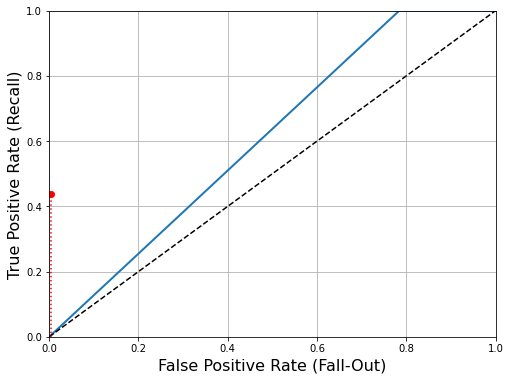

In [123]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [124]:
roc_auc_score(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))

0.607843137254902

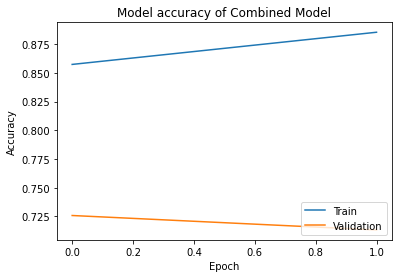

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.5230312347412109, 0.8019461035728455]


In [125]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)
print(plot_combined)

print("test loss, test accuracy:", model_results_comb)

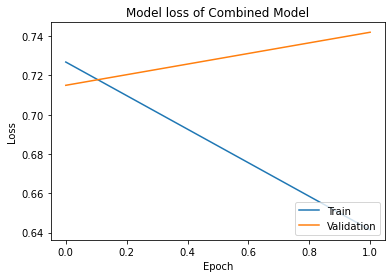

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.5230312347412109, 0.8019461035728455]


In [126]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined)
print(plot_loss)
#test accuracy and loss 
print("test loss, test accuracy:", model_results_comb)

#### Labse

In [127]:
#make sure numpy array
train_data_labse = np.array(combined_features_train_labse).astype(np.float32)
valid_data_labse = np.array(combined_features_valid_labse).astype(np.float32)
test_data_labse = np.array(combined_features_test_labse).astype(np.float32)

train_labels_labse = labels_train_labse
valid_labels_labse = labels_valid_labse
test_labels_labse = labels_test_labse

In [128]:
#gets shape of the data for the model
input_shape_combined_labse=valid_data_labse[0].shape
input_shape_combined_labse

(793,)

In [129]:
#set seed
random_seeds(1234)

In [130]:
#test model_flow
Combined_model_labse = model_flow("Combined",num_of_labels, input_shape_combined_labse)

In [131]:
#model summary
Combined_model_labse.summary()

Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 793)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50816     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

In [132]:
#Compile  model
Combined_model_labse.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [133]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined_labse = Combined_model_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                                      validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data
Epoch 1/2
7718/7718 [==============================] - 14s 2ms/step - loss: 0.5857 - accuracy: 0.8681 - val_loss: 1.2143 - val_accuracy: 0.7511
Epoch 2/2
7718/7718 [==============================] - 14s 2ms/step - loss: 0.3676 - accuracy: 0.9212 - val_loss: 1.7860 - val_accuracy: 0.7470


In [134]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb_labse = Combined_model_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate on test data
3484/3484 [==============================] - 2s 683us/step - loss: 0.4727 - accuracy: 0.8251


In [135]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_labse.save('data/s3_data/model_output/full_test_interp_Combined_model_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [136]:
from tensorflow.keras.models import load_model

Combined_model_labse = load_model('data/s3_data/model_output/full_test_interp_Combined_model_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [137]:
#test predict_test
metrics_report_comb_labse=predict_test(Combined_model_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_labse)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     31795
           1       0.21      0.35      0.26      3044

    accuracy                           0.83     34839
   macro avg       0.57      0.61      0.58     34839
weighted avg       0.87      0.83      0.84     34839



In [138]:
predictions = Combined_model_labse.predict(test_data_labse)

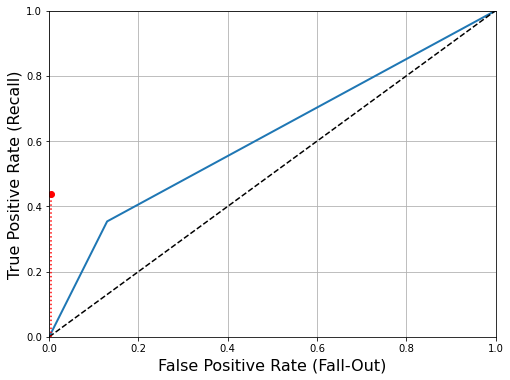

In [139]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [140]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.6120209718591858

In [141]:
test_preds_tweets = predict_tweet_text(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
88,'1.2924467659380244e+18',jpelzer happy married life sir,Harris72131392,1.286608e+18,0,0.999898
73,'1.2905278435421676e+18',jame deane zhanglifan,Lance15234488,1.283652e+18,0,0.999874
51,'1.2910497478688645e+18',promise he will be successful alexanderstew h...,elaxystewart,1.281469e+18,0,0.999115
57,'1.2819424790891438e+18',RT arynewsud ARYNewsUrdu https co MgElm b,MariamS44046005,1.281940e+18,0,0.990508
79,'1.290540973366186e+18',EricTrump A,HungDo67500733,1.285195e+18,0,0.976738


In [142]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

Accounts

Test

In [143]:
test_account_preds_comb_labse = predict_account(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [144]:
test_account_preds_comb_labse.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

In [145]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       1.00      0.36      0.53       102
           1       0.06      1.00      0.11         4

    accuracy                           0.39       106
   macro avg       0.53      0.68      0.32       106
weighted avg       0.96      0.39      0.52       106



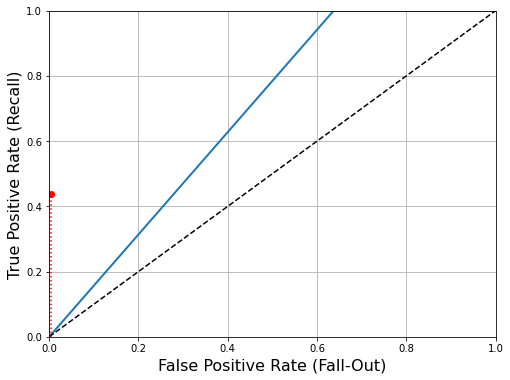

In [146]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [147]:
roc_auc_score(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))

0.6813725490196079

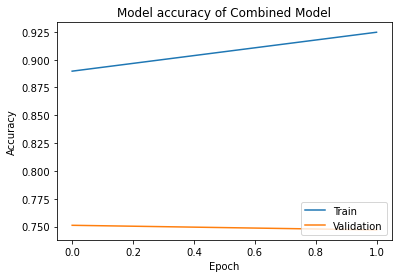

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.4726752042770386, 0.8251097798347473]


In [148]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined_labse)
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb_labse)

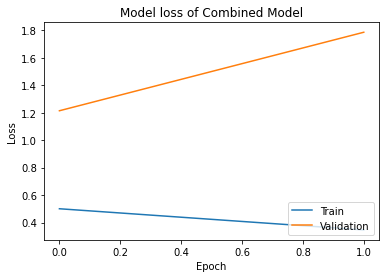

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.4726752042770386, 0.8251097798347473]


In [149]:
#train vs validation loss plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined_labse)
print(plot_loss)
#test loss and accuracy
print("test loss, test accuracy:", model_results_comb_labse)

### 3. Fine Tuning Models

In [150]:
#Callbacks
callback1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [151]:
#clears training output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

#### Account Only Model 

In [152]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(25,)

In [153]:
def tuner_builder1(hp):
    inputs = keras.Input(shape=input_shape_acc, name="Tuned_Account_Info_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Account_Info_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [154]:
#tuner settings 
Acc_info_tuner = kt.Hyperband(
    tuner_builder1,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_acc_info3',
    project_name = 'Parameters_trials_acc_info897715') # Need to be unique with each run!

INFO:tensorflow:Reloading Oracle from existing project Trial_run_acc_info3/Parameters_trials_acc_info897715/oracle.json
INFO:tensorflow:Reloading Tuner from Trial_run_acc_info3/Parameters_trials_acc_info897715/tuner0.json


In [155]:
#run through tuner
Acc_info_tuner.search(train_data_acc, train_labels,validation_data=(valid_data_acc, valid_labels),callbacks=[callback1,ClearTrainingOutput()])


Trial 76 Complete [00h 00m 33s]
val_accuracy: 0.8188211917877197

Best val_accuracy So Far: 0.8504270911216736
Total elapsed time: 00h 29m 12s
INFO:tensorflow:Oracle triggered exit


In [156]:
#gets best parameters
best_hyper_Acc_info = Acc_info_tuner.get_best_hyperparameters(1)[0]
best_hyper_Acc_info
    

In [157]:
print('Best Parameters for 1st Dense layer is', best_hyper_Acc_info.get('units'))

Best Parameters for 1st Dense layer is 90


In [158]:
print('Best Parameters for 2nd Dense layer is', best_hyper_Acc_info.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [159]:
print('Best Parameters for 3rd Dense layer is', best_hyper_Acc_info.get('units2'))

Best Parameters for 3rd Dense layer is 40


In [160]:
print('Best Parameters for Dropout layer is', best_hyper_Acc_info.get('dropout'))

Best Parameters for Dropout layer is 0.0


In [161]:
print('Best learning rate for the ADAM is', best_hyper_Acc_info.get('learning_rate'))

Best learning rate for the ADAM is 0.002166277197701016


In [162]:
#applies to tuning to model
Acc_info_model_tuned= Acc_info_tuner.hypermodel.build(best_hyper_Acc_info)

In [163]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned Account Information model")
history_acc_info_tuned = Acc_info_model_tuned.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight = class_weights)

Fit model on training data with tuned Account Information model
Epoch 1/2
7718/7718 [==============================] - 15s 2ms/step - loss: 0.4526 - accuracy: 0.8926 - val_loss: 1.9881 - val_accuracy: 0.7287
Epoch 2/2
7718/7718 [==============================] - 14s 2ms/step - loss: 0.1904 - accuracy: 0.9624 - val_loss: 2.6106 - val_accuracy: 0.7248


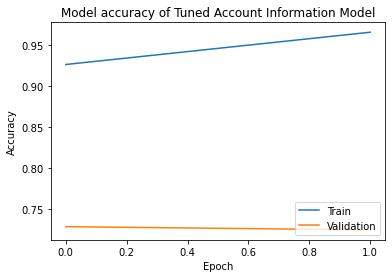

In [164]:
plot_acc_info_tuned=accuracy_plot('Model accuracy of Tuned Account Information Model', history_acc_info_tuned)

In [165]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned Account Information model on test data")
acc_info_tuned_results = Acc_info_model_tuned.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate tuned Account Information model on test data
3484/3484 [==============================] - 3s 762us/step - loss: 0.4641 - accuracy: 0.8929


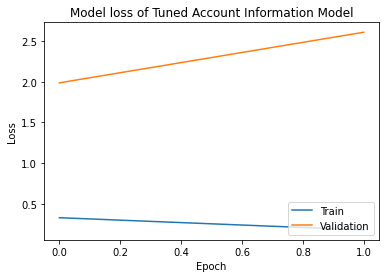

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.46414849162101746, 0.8929360508918762]


In [166]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Account Information Model', history_acc_info_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", acc_info_tuned_results)

#### Save Model 

In [167]:
from tensorflow.keras.layers import LeakyReLU
Acc_info_model_tuned.save('data/s3_data/model_output/full_test_interp_Acc_info_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [168]:
from tensorflow.keras.models import load_model
Acc_info_model_tuned = load_model('data/s3_data/model_output/full_test_interp_Acc_info_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict 

Tweets

In [169]:
#test predict_test
metrics_report_acc_tuned=predict_test(Acc_info_model_tuned,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc_tuned)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     31795
           1       0.40      0.43      0.41      3044

    accuracy                           0.89     34839
   macro avg       0.67      0.68      0.68     34839
weighted avg       0.90      0.89      0.89     34839



In [170]:
predictions = Acc_info_model_tuned.predict(test_data_acc)

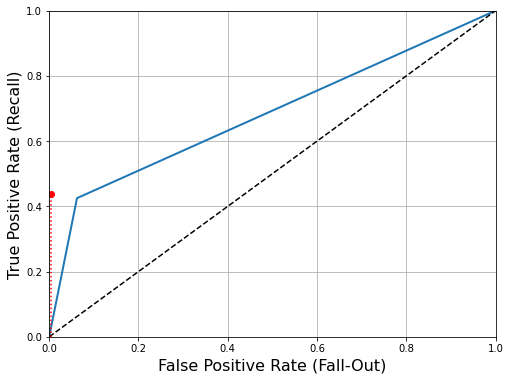

In [171]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [172]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.6814123060448641

In [173]:
test_preds_tweets = predict_tweet_text(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
2,'1.2818313918278287e+18',QasimKhanSuri Ameen,Haseenk53608977,1.278264e+18,0,0.981052
5,'1.2787969779715277e+18',AmbassadorSadiq Sir common man cross chaman b...,Mohamme94165240,1.278352e+18,0,0.952807
56,'1.2818856368703242e+18',chdsheng SpokespersonCHN Australia is the Ame...,AlexV64818523,1.281877e+18,0,0.947070
57,'1.2819424790891438e+18',RT arynewsud ARYNewsUrdu https co MgElm b,MariamS44046005,1.281940e+18,0,0.916617
62,'1.286562705046823e+18',SpokespersonCHN,o952OS2S0uzEpKk,1.282586e+18,0,0.912115


In [174]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [175]:
test_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_account_preds_acc_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
67,elaxystewart,0,211.669342,4.319782e-01,1
41,NicolasCrow8,0,20.976557,2.527296e-01,1
52,WvU46oIgqdh88d0,0,15.362998,9.037058e-01,1
88,o952OS2S0uzEpKk,0,13.515825,7.508792e-01,1
104,yQg5K3B7ZvLSZXQ,0,9.337574,4.914513e-01,1
91,realmurongchong,0,7.686707,5.158864e-02,0
94,rotemsingavi,0,7.554114,9.442643e-01,1
57,bingguan5,0,7.376545,3.512640e-01,1
48,THosinkhil,0,7.276752,1.136992e-01,0
101,wangzhizhi9,0,6.945363,4.340852e-01,1


In [176]:
test_account_preds_acc_tuned.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [177]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc_tuned_tuned = classification_report(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
print(report_te_acc_tuned_tuned)

              precision    recall  f1-score   support

           0       0.97      0.56      0.71       102
           1       0.04      0.50      0.08         4

    accuracy                           0.56       106
   macro avg       0.50      0.53      0.39       106
weighted avg       0.93      0.56      0.68       106



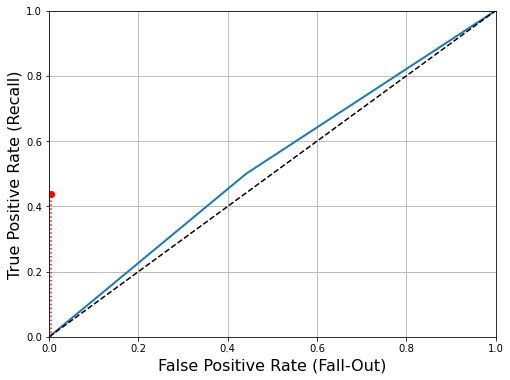

In [178]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [179]:
roc_auc_score(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))

0.5294117647058824

#### Combined Model

Multilingual BERT

In [180]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(793,)

In [181]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [182]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined3',
    project_name = 'Parameters_trials_combined_3565766') # Need to be unique with each run!

In [183]:
#run through tuner
Combined_tuner.search(train_data, train_labels,validation_data=(valid_data, valid_labels),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 46s]
val_accuracy: 0.8159738183021545

Best val_accuracy So Far: 0.8251138925552368
Total elapsed time: 00h 47m 24s
INFO:tensorflow:Oracle triggered exit


In [184]:
#gets best parameters
best_hyper_combined = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined

In [185]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined.get('units'))

Best Parameters for 1st Dense layer is 110


In [186]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [187]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined.get('units2'))

Best Parameters for 3rd Dense layer is 100


In [188]:
print('Best Parameters for Dropout layer is', best_hyper_combined.get('dropout'))

Best Parameters for Dropout layer is 0.4


In [189]:
print('Best learning rate for the ADAM is', best_hyper_combined.get('learning_rate'))

Best learning rate for the ADAM is 0.0014296058506251123


In [190]:
#applies to tuning to model
Combined_model_tuned= Combined_tuner.hypermodel.build(best_hyper_combined)

In [191]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned = Combined_model_tuned.fit(train_data, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data with tuned model
Epoch 1/2
7718/7718 [==============================] - 15s 2ms/step - loss: 0.7898 - accuracy: 0.8516 - val_loss: 0.8190 - val_accuracy: 0.7129
Epoch 2/2
7718/7718 [==============================] - 16s 2ms/step - loss: 0.6653 - accuracy: 0.8784 - val_loss: 0.8597 - val_accuracy: 0.7282


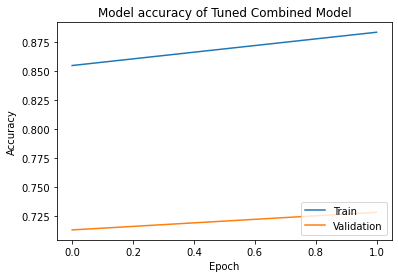

In [192]:
plot_combined_tuned=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned)

In [193]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results = Combined_model_tuned.evaluate(test_data, test_labels, batch_size=10)

Evaluate tuned model on test data
3484/3484 [==============================] - 3s 817us/step - loss: 0.4785 - accuracy: 0.81770s - loss: 0.4766 - accuracy: 0.81


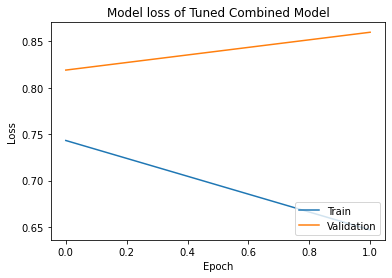

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.4784790873527527, 0.8177329897880554]


In [194]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Combined Model', history_combined_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results)

#### Save Model 

In [195]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned.save('data/s3_data/model_output/full_test_interp_Combined_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Import Model 

In [196]:
from tensorflow.keras.models import load_model
Combined_model_tuned = load_model('data/s3_data/model_output/full_test_interp_Combined_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict

Tweets

In [197]:
#test predict_test
metrics_report_comb_tuned=predict_test(Combined_model_tuned,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb_tuned)

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     31795
           1       0.22      0.44      0.30      3044

    accuracy                           0.82     34839
   macro avg       0.58      0.65      0.60     34839
weighted avg       0.88      0.82      0.84     34839



In [198]:
predictions = Combined_model_tuned.predict(test_data)

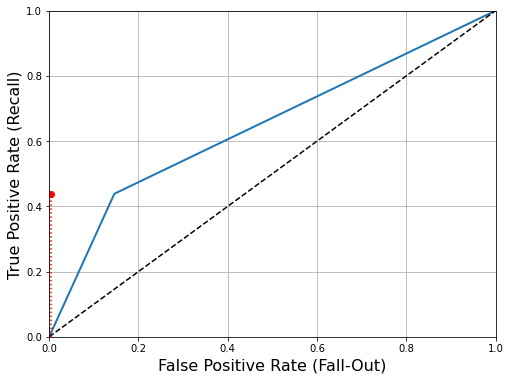

In [199]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [200]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.6463006636015588

In [201]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
73,'1.2905278435421676e+18',jame deane zhanglifan,Lance15234488,1.283652e+18,0,1.000000
42,'1.2812576462308147e+18',TonySta Mane pahly bi kaya tha per os account...,abuzar_malik206,1.280674e+18,0,1.000000
57,'1.2819424790891438e+18',RT arynewsud ARYNewsUrdu https co MgElm b,MariamS44046005,1.281940e+18,0,0.999939
84,'1.287970610992124e+18',GaoyoaG JLin,JeremyC86978845,1.286251e+18,0,0.999687
76,'1.3114899972378993e+18',PDChinese,lpd37684021,1.284453e+18,0,0.997653


In [202]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [203]:
test_account_preds_comb_tuned = predict_account(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)

In [204]:
test_account_preds_comb_tuned.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [205]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.93      0.13      0.22       102
           1       0.03      0.75      0.06         4

    accuracy                           0.15       106
   macro avg       0.48      0.44      0.14       106
weighted avg       0.89      0.15      0.22       106



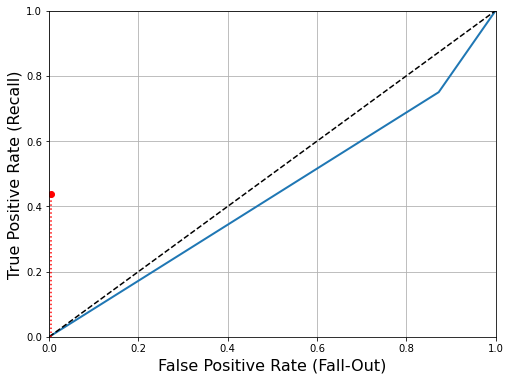

In [206]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [207]:
roc_auc_score(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))

0.4387254901960784

Combined Model with LAbse

In [208]:
#gets shape of the data for the model
input_shape_combined_labse=train_data_labse[0].shape
input_shape_combined_labse

(793,)

In [209]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined_labse, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [210]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined_labse_6493') # Need to be unique with each run!

In [211]:
#run through tuner
Combined_tuner.search(train_data_labse, train_labels_labse,validation_data=(valid_data_labse, valid_labels_labse),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [01h 29m 07s]
val_accuracy: 0.8220102787017822

Best val_accuracy So Far: 0.833684504032135
Total elapsed time: 02h 20m 12s
INFO:tensorflow:Oracle triggered exit


In [212]:
#gets best parameters
best_hyper_combined_labse = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined_labse

In [213]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined_labse.get('units'))

Best Parameters for 1st Dense layer is 70


In [214]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined_labse.get('units1'))

Best Parameters for 2nd Dense layer is 200


In [215]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined_labse.get('units2'))

Best Parameters for 3rd Dense layer is 20


In [216]:
print('Best Parameters for Dropout layer is', best_hyper_combined_labse.get('dropout'))

Best Parameters for Dropout layer is 0.4


In [217]:
print('Best learning rate for the ADAM is', best_hyper_combined_labse.get('learning_rate'))

Best learning rate for the ADAM is 0.004762726870866379


In [218]:
#applies to tuning to model
Combined_model_tuned_labse= Combined_tuner.hypermodel.build(best_hyper_combined_labse)

In [219]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned_labse = Combined_model_tuned_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                   validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data with tuned model
Epoch 1/2
7718/7718 [==============================] - 1242s 161ms/step - loss: 0.6597 - accuracy: 0.8706 - val_loss: 0.8913 - val_accuracy: 0.7654
Epoch 2/2
7718/7718 [==============================] - 381s 49ms/step - loss: 0.4523 - accuracy: 0.9114 - val_loss: 2.4329 - val_accuracy: 0.7239


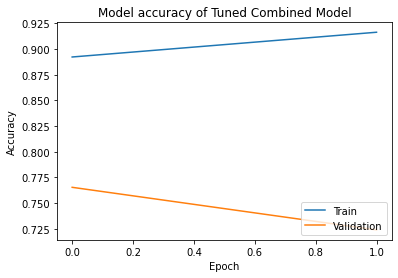

In [220]:
plot_combined_tuned_labse=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)

In [221]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results_labse = Combined_model_tuned_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate tuned model on test data
3484/3484 [==============================] - 5s 1ms/step - loss: 0.4120 - accuracy: 0.8273


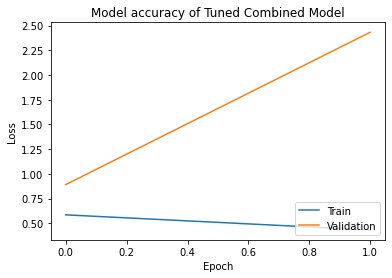

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.4120442271232605, 0.8273199796676636]


In [222]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results_labse)

In [223]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned_labse.save('data/s3_data/model_output/full_test_interp_Combined_model_tuned_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [224]:
from tensorflow.keras.models import load_model
Combined_model_tuned_labse= load_model('data/s3_data/model_output/full_test_interp_Combined_model_tuned_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [225]:
#test predict_test
metrics_report_comb_tuned_labse=predict_test(Combined_model_tuned_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     31795
           1       0.25      0.48      0.33      3044

    accuracy                           0.83     34839
   macro avg       0.60      0.67      0.61     34839
weighted avg       0.88      0.83      0.85     34839



In [226]:
predictions = Combined_model_tuned_labse.predict(test_data_labse)

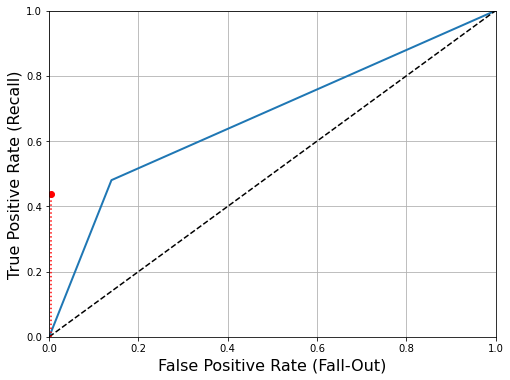

In [227]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [228]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.6704166020037613

In [229]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
42,'1.2812576462308147e+18',TonySta Mane pahly bi kaya tha per os account...,abuzar_malik206,1.280674e+18,0,0.999998
88,'1.2924467659380244e+18',jpelzer happy married life sir,Harris72131392,1.286608e+18,0,0.999578
57,'1.2819424790891438e+18',RT arynewsud ARYNewsUrdu https co MgElm b,MariamS44046005,1.281940e+18,0,0.987389
49,'1.3028599025164206e+18',RT HSF Pakistan HSF Pakistan is pleased to inv...,rayyanm123,1.281279e+18,0,0.962655
41,'1.2829102743459922e+18',RT China CCYL https,yQg5K3B7ZvLSZXQ,1.280441e+18,0,0.954250


In [230]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/full_test_interp/test_tweets_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

Test

In [231]:
test_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [232]:
test_account_preds_comb_tuned_labse.to_csv(results_bucket + 'account_level_results/full_test_interp/test_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [233]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       1.00      0.53      0.69       102
           1       0.08      1.00      0.14         4

    accuracy                           0.55       106
   macro avg       0.54      0.76      0.42       106
weighted avg       0.97      0.55      0.67       106



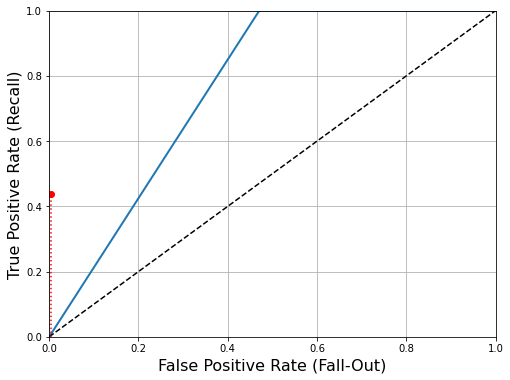

In [234]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [235]:
roc_auc_score(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))

0.7647058823529411